In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import selfies as sf
from rdkit.Chem import MolFromSmiles, Draw
from chem_env import calculate_score 

Found local copy...
Found local copy...
Found local copy...


In [2]:
sns.set_theme(style='whitegrid')

In [3]:
PROPERTY_NAME = ('PLOGP', 'QED', 'SIMILARITY')[0]

In [4]:
INTRINSIC_TYPES = ('None', 'COUNTING_0', 'COUNTING', 'MEMORY_0', 'MEMORY', 'PREDICTION_0', 'PREDICTION')

In [5]:
class CONFIGS:
    class CONFIGS_NONE:
        def __init__(self, entropy_weight='0.02'):
            self.BUFFER_SIZE        = 1000
            self.SEQUENCE_MAXLEN    = 35
            self.INTRINSIC_WEIGHT   = '0.0'
            self.DISCOUNT_FACTOR    = '1.0'
            self.EPOCHS             = 4
            self.USE_L2NORM         = 'True'
            self.USE_GREEDY         = 'False'
            self.EPOCHS_PRED_NET    = 0
            self.ENTROPY_WEIGHT     = entropy_weight
            self.FINGERPRINT_SIZE   = 256
            self.FINGERPRINT_RADIUS = 2
            self.LSH_SIZE           = 32
        
    class CONFIGS_CNT:
        def __init__(self, alpha, entropy_weight):
            self.BUFFER_SIZE        = 1000
            self.SEQUENCE_MAXLEN    = 35
            self.INTRINSIC_WEIGHT   = alpha
            self.DISCOUNT_FACTOR    = '1.0'
            self.EPOCHS             = 4
            self.USE_L2NORM         = 'True'
            self.USE_GREEDY         = 'False'
            self.EPOCHS_PRED_NET    = 0
            self.ENTROPY_WEIGHT     = entropy_weight
            self.FINGERPRINT_SIZE   = 256
            self.FINGERPRINT_RADIUS = 2
            self.LSH_SIZE           = 32
        
    class CONFIGS_MEM:
        def __init__(self, alpha, entropy_weight):
            self.BUFFER_SIZE        = 1000
            self.SEQUENCE_MAXLEN    = 35
            self.INTRINSIC_WEIGHT   = alpha
            self.DISCOUNT_FACTOR    = '1.0'
            self.EPOCHS             = 4
            self.USE_L2NORM         = 'True'
            self.USE_GREEDY         = 'False'
            self.EPOCHS_PRED_NET    = 0
            self.ENTROPY_WEIGHT     = entropy_weight
            self.FINGERPRINT_SIZE   = 256
            self.FINGERPRINT_RADIUS = 2
            self.LSH_SIZE           = 32
        
    class CONFIGS_PRED:
        def __init__(self, alpha, entropy_weight):
            self.BUFFER_SIZE        = 1000
            self.SEQUENCE_MAXLEN    = 35
            self.INTRINSIC_WEIGHT   = alpha
            self.DISCOUNT_FACTOR    = '1.0'
            self.EPOCHS             = 4
            self.USE_L2NORM         = 'True'
            self.USE_GREEDY         = 'False'
            self.EPOCHS_PRED_NET    = 0
            self.ENTROPY_WEIGHT     = entropy_weight
            self.FINGERPRINT_SIZE   = 256
            self.FINGERPRINT_RADIUS = 2
            self.LSH_SIZE           = 32
        
    configs_none   = CONFIGS_NONE(entropy_weight='0.02')
    configs_cnt_0  = CONFIGS_CNT('0.0', entropy_weight='0.02')
    configs_cnt_1  = CONFIGS_CNT('0.1', entropy_weight='0.02')
    configs_mem_0  = CONFIGS_MEM('0.0', entropy_weight='0.02')
    configs_mem_1  = CONFIGS_MEM('0.1', entropy_weight='0.02')
    configs_pred_0 = CONFIGS_PRED('0.0', entropy_weight='0.02')
    configs_pred_1 = CONFIGS_PRED('0.1', entropy_weight='0.02')
    
    def __getitem__(self, k):
        if k == 'None':
            return self.configs_none
        elif k == 'COUNTING':
            return self.configs_cnt_1
        elif k == 'MEMORY':
            return self.configs_mem_1
        elif k == 'PREDICTION':
            return self.configs_pred_1
        elif k == 'COUNTING_0':
            return self.configs_cnt_0
        elif k == 'MEMORY_0':
            return self.configs_mem_0
        elif k == 'PREDICTION_0':
            return self.configs_pred_0
    
configs = CONFIGS()

In [6]:
def get_input_dir(prop_name, intrinsic_type, configs):
    input_dir = 'results'
    input_dir = os.path.join(input_dir, f'scoringFnc_{prop_name}')
    input_dir = os.path.join(input_dir, f'curiosityBufferSize_{configs[intrinsic_type].BUFFER_SIZE}')
    input_dir = os.path.join(input_dir, f'maxSL_{configs[intrinsic_type].SEQUENCE_MAXLEN}')
    input_dir = os.path.join(input_dir, f'intrinsicRewardType_{intrinsic_type.split("_")[0]}')
    input_dir = os.path.join(input_dir, f'intrinsicRewardWeight_{configs[intrinsic_type].INTRINSIC_WEIGHT}')
    input_dir = os.path.join(input_dir, f'discountFactor_{configs[intrinsic_type].DISCOUNT_FACTOR}')
    input_dir = os.path.join(input_dir, f'kEpochs_{configs[intrinsic_type].EPOCHS}')
    input_dir = os.path.join(input_dir, f'l2Curosity_{configs[intrinsic_type].USE_L2NORM}')
    input_dir = os.path.join(input_dir, f'greedyCuriosity_{configs[intrinsic_type].USE_GREEDY}')
    input_dir = os.path.join(input_dir, f'nEpochsPredNetwork_{configs[intrinsic_type].EPOCHS_PRED_NET}')
    input_dir = os.path.join(input_dir, f'entropyWeight_{configs[intrinsic_type].ENTROPY_WEIGHT}')
    input_dir = os.path.join(input_dir, f'fingerprintBits_{configs[intrinsic_type].FINGERPRINT_SIZE}')
    input_dir = os.path.join(input_dir, f'fingerprintRadius_{configs[intrinsic_type].FINGERPRINT_RADIUS}')
    input_dir = os.path.join(input_dir, f'lshBits_{configs[intrinsic_type].LSH_SIZE}')
    return input_dir

In [7]:
list_input_dir = [get_input_dir(PROPERTY_NAME, x, configs) for x in INTRINSIC_TYPES]

# 1. Best Molecule

In [8]:
def get_best_smiles(input_dir):
    filepath_best_selfies = os.path.join(input_dir, 'selfies_best_sample_list_0.npy')
    selfies_best_sample_list = np.load(filepath_best_selfies, allow_pickle=True).tolist()

    best_molecule_selfies = selfies_best_sample_list[-1]
    best_molecule_smiles  = sf.decoder(best_molecule_selfies)
    best_molecule_prop    = calculate_score(best_molecule_smiles, MolFromSmiles(best_molecule_smiles), PROPERTY_NAME)

    ## Reference: chem_env.calculate_score
    if PROPERTY_NAME == 'PLOGP':
        best_molecule_prop = best_molecule_prop * 10.
        
    return best_molecule_selfies, best_molecule_smiles, best_molecule_prop

In [9]:
list_best_smiles = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    best_molecule_selfies, best_molecule_smiles, best_molecule_prop = get_best_smiles(input_dir)
    list_best_smiles.append(best_molecule_smiles)
    print('========', intrinsic_type, '========')
    print('>>> BEST SELFIES:', best_molecule_selfies)
    print('>>> BEST SMILES:', best_molecule_smiles)
    print('>>> BEST PROP:', best_molecule_prop)
    print()

======== None ========
>>> BEST SELFIES: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C]
>>> BEST SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
>>> BEST PROP: 10.52348880026976

======== COUNTING_0 ========
>>> BEST SELFIES: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C]
>>> BEST SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
>>> BEST PROP: 10.52348880026976

======== COUNTING ========
>>> BEST SELFIES: [=S][S][C][C][S][S][S][=C][C][S][C@Hexpl][C][C][C@@Hexpl][S][P][S][NHexpl][P][S][O][P][=S][P][S][C@@Hexpl][C][S][S][S][S][S][C@expl][C@Hexpl]
>>> BEST SMILES: SSCCSSS=CCS[C@H]CC[C@@H]SPS[NH]PSOP=SPS[C@@H]CSSSSS[C@][C@H]
>>> BEST PROP: 9.850294514992724

======== MEMORY_0 ========
>>> BEST SELFIES: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C]
>>> BEST SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
>>> BEST PROP: 10.52348

# 2. History of best property scores

In [34]:
def get_history_of_best_property_scores(input_dir, T=1000):
    filepath = os.path.join(input_dir, 'best_molecule_property_0.npy')
    scores = np.load(filepath)
    return scores[:T]

In [35]:
frames = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    best_molecule_property = get_history_of_best_property_scores(input_dir)
    df = pd.DataFrame({
        'Episode':np.arange(len(best_molecule_property)),
        f'Best {PROPERTY_NAME}':best_molecule_property,
        'Intrinsic':intrinsic_type,
    })
    frames.append(df)
    
df_hist_best = pd.concat(frames, ignore_index=True)

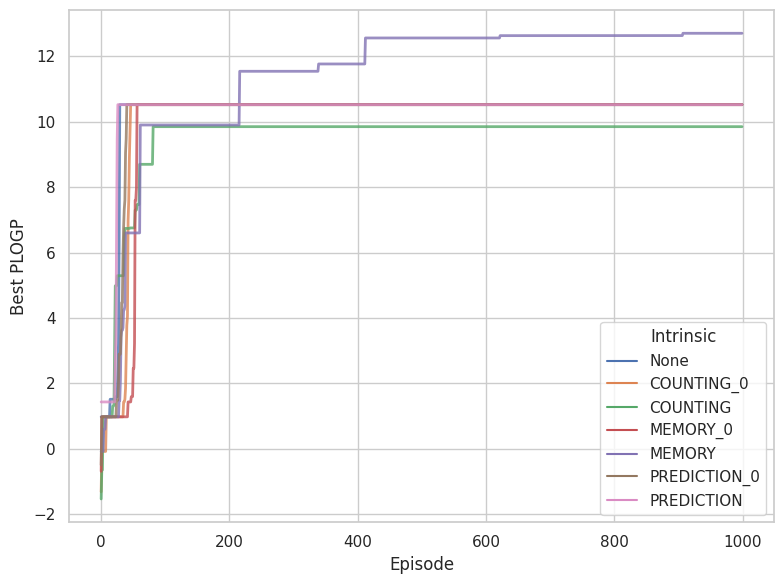

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))

sns.lineplot(data=df_hist_best,
             x='Episode', y=f'Best {PROPERTY_NAME}', hue='Intrinsic',
             ax=ax, linewidth=2, alpha=.8)

plt.tight_layout()
plt.show()

# 3. History of intrinsic reward values

In [37]:
def get_history_of_intrinsic_reward_values(input_dir, T=1000):
    filepath = os.path.join(input_dir, 'curiosity_error_hist_0.npy')
    scores = np.load(filepath)
    return scores[:T]

In [38]:
frames = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    intrinsic_reward_scores = get_history_of_intrinsic_reward_values(input_dir)
    df = pd.DataFrame({
        'Episode':np.arange(len(intrinsic_reward_scores)),
        'Average intrinsic reward':intrinsic_reward_scores,
        'Intrinsic':intrinsic_type,
    })
    frames.append(df)
    
df_hist_intrinsic = pd.concat(frames, ignore_index=True)

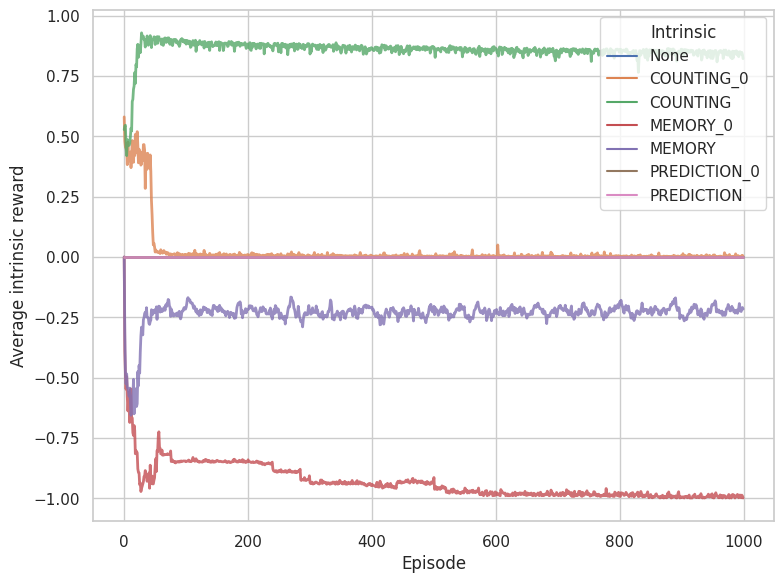

In [39]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))

sns.lineplot(data=df_hist_intrinsic,
             x='Episode', y='Average intrinsic reward', hue='Intrinsic',
             ax=ax, linewidth=2, alpha=.8)

plt.tight_layout()
plt.show()

# 4. History of average property scores

In [40]:
def get_history_of_average_property_scores(input_dir, T=1000):
    filepath = os.path.join(input_dir, 'molecule_property_hist_0.npy')
    scores = np.load(filepath)
    return scores[:T]

In [41]:
frames = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    best_molecule_property = get_history_of_average_property_scores(input_dir)
    df = pd.DataFrame({
        'Episode':np.arange(len(best_molecule_property)),
        f'Average {PROPERTY_NAME}':best_molecule_property,
        'Intrinsic':intrinsic_type,
    })
    frames.append(df)
    
df_hist_avg = pd.concat(frames, ignore_index=True)

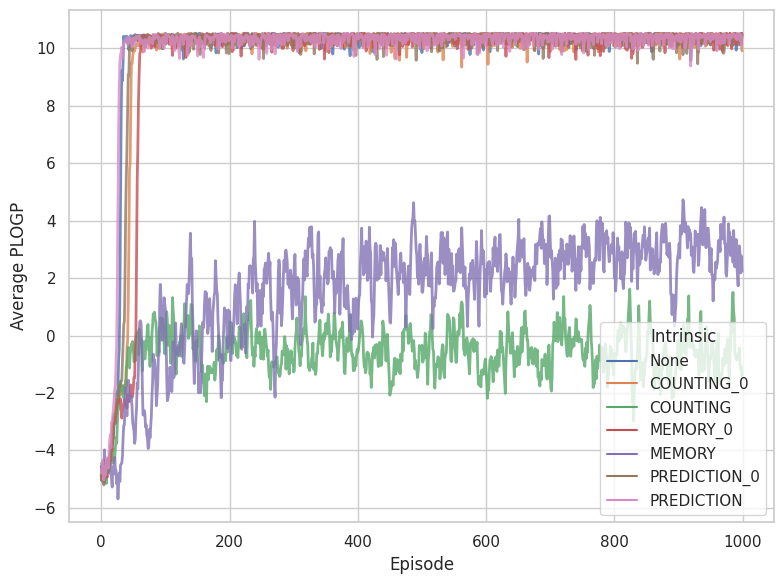

In [42]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))

sns.lineplot(data=df_hist_avg,
             x='Episode', y=f'Average {PROPERTY_NAME}', hue='Intrinsic',
             ax=ax, linewidth=2, alpha=.8)

plt.tight_layout()
plt.show()

# 5. History of reward values

In [43]:
def get_history_of_reward_values(input_dir, T=1000):
    filepath = os.path.join(input_dir, 'reward_hist_0.npy')
    scores = np.load(filepath)
    return scores[:T]

In [44]:
frames = []

for intrinsic_type, input_dir in zip(INTRINSIC_TYPES, list_input_dir):
    best_molecule_property = get_history_of_reward_values(input_dir)
    df = pd.DataFrame({
        'Episode':np.arange(len(best_molecule_property)),
        'Reward':best_molecule_property,
        'Intrinsic':intrinsic_type,
    })
    frames.append(df)
    
df_hist_reward = pd.concat(frames, ignore_index=True)

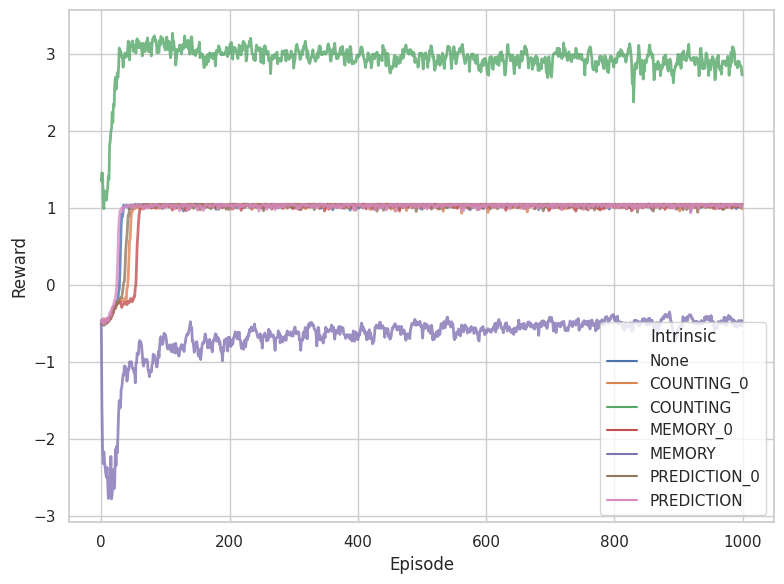

In [45]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))

sns.lineplot(data=df_hist_reward,
             x='Episode', y='Reward', hue='Intrinsic',
             ax=ax, linewidth=2, alpha=.8)

plt.tight_layout()
plt.show()